In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#New code for new dataset

import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

df=pd.read_csv('drive/My Drive/SteamDataset/newData/steam_data.csv')
df.info

<bound method DataFrame.info of                                                      url  \
0      https://store.steampowered.com/app/945360/Amon...   
1      https://store.steampowered.com/app/730/Counter...   
2      https://store.steampowered.com/app/1097150/Fal...   
3      https://store.steampowered.com/app/1158310/Cru...   
4      https://store.steampowered.com/app/1085660/Des...   
...                                                  ...   
81043  https://store.steampowered.com/bundle/2961/Ste...   
81044  https://store.steampowered.com/bundle/3123/Det...   
81045  https://store.steampowered.com/bundle/3175/Fea...   
81046  https://store.steampowered.com/bundle/3176/Fea...   
81047  https://store.steampowered.com/bundle/3237/Sho...   

                                   name  \
0                              Among Us   
1      Counter-Strike: Global Offensive   
2          Fall Guys: Ultimate Knockout   
3                    Crusader Kings III   
4                             De

In [ ]:
#Clean data

df=df.replace("-",np.nan)
df=df.dropna().drop_duplicates()
for column in df.columns:
    df=df[df[column].map(lambda x: x.isascii())]
df=df[['categories','user_reviews']]
df=df[df.user_reviews.str.contains("\%")]
df.info

<bound method DataFrame.info of                                               categories  \
3      Single-playerOnline PvPSteam AchievementsSteam...   
4      Single-playerOnline PvPOnline Co-opSteam Achie...   
12     Single-playerOnline Co-opLAN Co-opCross-Platfo...   
14     Online PvPOnline Co-opSteam AchievementsFull c...   
17     Single-playerMMOOnline PvPOnline Co-opCross-Pl...   
...                                                  ...   
80085  Single-playerOnline PvPShared/Split Screen PvP...   
80375  Single-playerSteam AchievementsFull controller...   
80553  Single-playerSteam AchievementsFull controller...   
80606  Single-playerOnline PvPShared/Split Screen PvP...   
80875  Single-playerOnline PvPShared/Split Screen PvP...   

                                            user_reviews  
3      Very Positive(5,359)- 91% of the 5,359 user re...  
4      Very Positive(9,147)- 87% of the 9,147 user re...  
12     Very Positive(1,791)- 85% of the 1,791 user re...  
14     Very

In [ ]:
#Create tags vocabulary

tags=set()
for index,row in df.iterrows():
    tagString=re.sub(r'( \(.*\))','',row.categories)
    tagString=re.sub("MMORPG|TV|SDK|MMO|FPV|VR|PvP|EULA",lambda ele: ele.group(0).title(),tagString)
    tagString=re.sub(r'([a-z])([A-Z]{1})',r'\1;\2',tagString)
    tagString=tagString.lower()
    tags.update({tag for tag in tagString.split(';')})
    row.categories=tagString
    reviews=re.sub(r'(\d+)(%)',r'%\1%',row.user_reviews)
    row.user_reviews=float(reviews.split("%")[1])/100

badTagWords=["requires","eula","incorporates","machine activation limit","anti-cheat"]
badTags=set()
for tag in tags:
    if any([x in tag for x in badTagWords]):badTags.add(tag)
tags-=badTags
tags=list(tags)
numTags=len(tags)
tagVocab={}
for index in range(numTags):
    tagVocab[tags[index]]=index

modelData=pd.DataFrame(columns=[*tags,"User Reviews"])
modelData.info


<bound method DataFrame.info of Empty DataFrame
Columns: [shared/split screen co-op, steam achievements, remote play on tv, partial controller support, dragon ball fighter, full controller support, steam, civ, online pvp, commentary available, cross-platform multiplayer, di, lan co-op, stats, steam leaderboards, lan pvp, steam cloud, remote play on phone, in-app purchases, downloadable content, bio, uk, remote play together, day, kl2full, remote play on tablet, includes level editor, includes source sdk, mmo, dragon age: origins - ultimate edition, single-player, spell, shared/split screen pvp, shield, electronic arts software end user license agreement, steam trading cards, us, ea play terms, online co-op, steam turn notifications, captions available, vr collectibles, duck, steam workshop, proof, User Reviews]
Index: []

[0 rows x 46 columns]>

In [ ]:
#Create training and testing data

for index,row in df.iterrows():
    vocabVector=[0]*(numTags+1)
    gameTags=row.categories.split(";")
    vocabIndices=[tagVocab[tag] for tag in gameTags if tag in tagVocab]
    for index in vocabIndices:
        vocabVector[index]=1
    vocabVector[-1]=row.user_reviews
    modelData.loc[len(modelData)]=vocabVector

scaler=MinMaxScaler()
modelData.info
X=modelData.drop('User Reviews',axis=1)
y=pd.DataFrame(scaler.fit_transform(modelData['User Reviews'].to_numpy().reshape(-1,1)))
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=50)

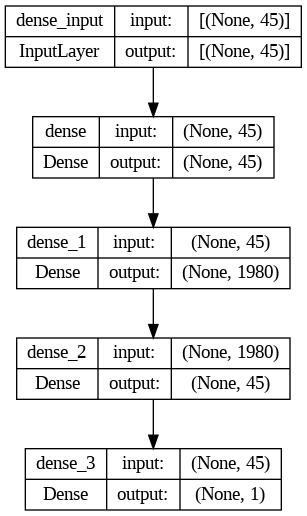

In [ ]:
#Create Model

model = tf.keras.Sequential()
model.add(Dense(numTags, input_dim=numTags, activation='linear'))
model.add(Dense(numTags*(numTags-1),activation='relu'))
model.add(Dense(numTags, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])
keras.utils.plot_model(model, "test.png", show_shapes=True)

In [ ]:
#Train Model

history = model.fit(X_train, y_train, epochs=15, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/15
4/4 [==============================] - 5s 139ms/step - loss: 0.4710 - mse: 0.3064 - val_loss: 0.3066 - val_mse: 0.1333
Epoch 2/15
4/4 [==============================] - 0s 19ms/step - loss: 0.2247 - mse: 0.0828 - val_loss: 0.2190 - val_mse: 0.0645
Epoch 3/15
4/4 [==============================] - 0s 23ms/step - loss: 0.1863 - mse: 0.0495 - val_loss: 0.1701 - val_mse: 0.0481
Epoch 4/15
4/4 [==============================] - 0s 34ms/step - loss: 0.1608 - mse: 0.0469 - val_loss: 0.1351 - val_mse: 0.0272
Epoch 5/15
4/4 [==============================] - 0s 39ms/step - loss: 0.1320 - mse: 0.0272 - val_loss: 0.1364 - val_mse: 0.0268
Epoch 6/15
4/4 [==============================] - 0s 27ms/step - loss: 0.1195 - mse: 0.0257 - val_loss: 0.1290 - val_mse: 0.0276
Epoch 7/15
4/4 [==============================] - 0s 61ms/step - loss: 0.1088 - mse: 0.0227 - val_loss: 0.1137 - val_mse: 0.0216
Epoch 8/15
4/4 [==============================] - 0s 49ms/step - loss: 0.1078 - mse: 0.0217 - va

In [ ]:
#Evaluate Model

mae,mse = model.evaluate(X_test, y_test)
print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)

3/3 [==============================] - 0s 9ms/step - loss: 0.0971 - mse: 0.0196
Mean Absolute Error: 0.09709897637367249
Mean Square Error: 0.019591867923736572


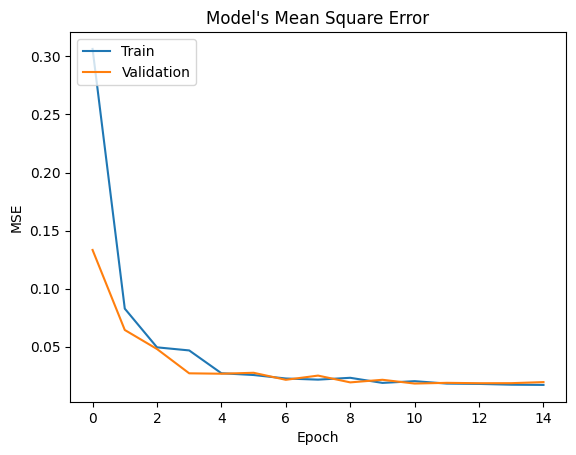

In [ ]:
#Plot Mean Square Error

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title("Model's Mean Square Error")
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

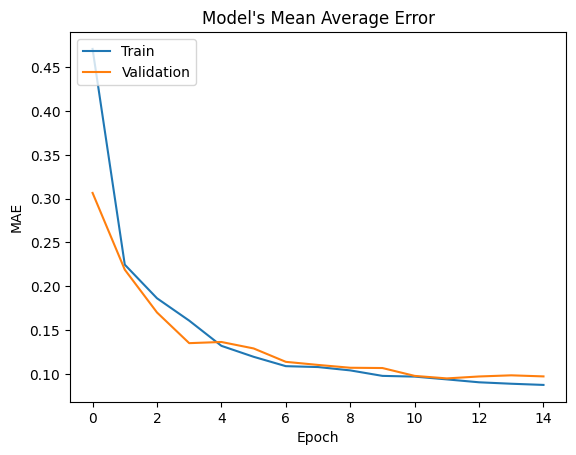

In [ ]:
#Plot Mean Average Error

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Mean Average Error")
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()